# Forecast Bitcoin's Realized Volatility using GARCH Models

This analysis has an objective of forecasting Bitcoin's volatility in shorter time periods.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

# Dataset

The historical dataset of Bitcoin Open/Close/High/Low prices were obtained from CoinMetrics. The dataframe below contains hourly data of cryptocurrencies in btc market from 2021-01-01 00:00:00+00:00 to 2021-12-31 23:00:00+00:00.

In [2]:
df = pd.read_csv("out.csv")
df.head()

,time,market,price_open,price_close,price_high,price_low,vwap,volume,candle_usd_volume,candle_trades_count
0,2021-01-01 00:00:00+00:00,btc,28923.63,28995.13,29031.34,28690.17,28881.607315,2311.811445,6.693244e+07,58389.0
1,2021-01-01 01:00:00+00:00,btc,28995.13,29409.99,29470.00,28960.35,29308.867298,5403.068471,1.586215e+08,103896.0
2,2021-01-01 02:00:00+00:00,btc,29410.00,29194.65,29465.26,29120.03,29293.569821,2384.231560,7.002218e+07,57646.0
3,2021-01-01 03:00:00+00:00,btc,29195.25,29278.40,29367.00,29150.02,29261.245272,1461.345077,4.284993e+07,42510.0
4,2021-01-01 04:00:00+00:00,btc,29278.41,29220.31,29395.00,29029.40,29250.867652,2038.046803,5.977760e+07,55414.0


In [3]:
df.isnull().values.any()

True

In [4]:
df.loc[df['price_close'].isnull(),'value_is_NaN'] = 'Yes'
df[df['value_is_NaN'] == "Yes"]

,time,market,price_open,price_close,price_high,price_low,vwap,volume,candle_usd_volume,candle_trades_count,value_is_NaN
7841,2021-11-24 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes


In [5]:
df['price_close'].interpolate(method='linear', inplace=True)
df.iloc[[7841],:]

,time,market,price_open,price_close,price_high,price_low,vwap,volume,candle_usd_volume,candle_trades_count,value_is_NaN
7841,2021-11-24 00:30:00+00:00,NaN,NaN,57266.315,NaN,NaN,NaN,NaN,NaN,NaN,Yes


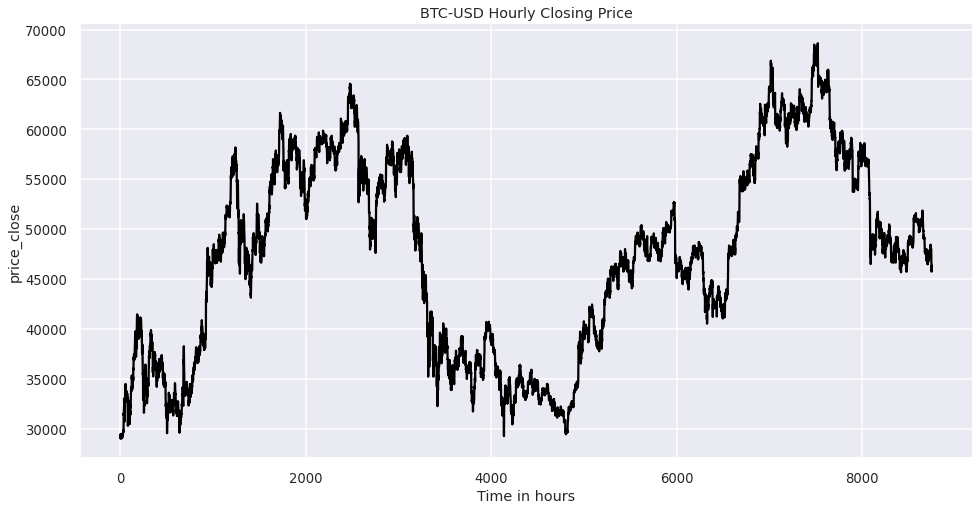

In [6]:
sns.set_context("talk", font_scale=0.8)
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(16,8))
    sns.lineplot(x=df.index, y=df.price_close, color='black')
    ax.set_title('BTC-USD Hourly Closing Price')  
    ax.set_xlabel("Time in hours") 

Historical Volatility (HV) or Realized Volatility is the actual volatility demonstrated by the underlying over a period of time. Realized Volatility is commonly calculated as the standard deviation of price returns, which is the dollar change in price as a percentage of previous day's price.

In [7]:
# Certain columns are not needed for analysis and are deleted
df = df.drop(columns=["value_is_NaN", "vwap", "candle_usd_volume", "candle_trades_count"])

In [8]:
# Calculate price_returns
df['returns'] = 100 * df.price_close.pct_change().dropna()
df['log_returns'] = np.log(df.price_close/df.price_close.shift(1))
df["recal"] = np.log(df["returns"]/100+1)
df.dropna(inplace=True)
df.head()

,time,market,price_open,price_close,price_high,price_low,volume,returns,log_returns,recal
1,2021-01-01 01:00:00+00:00,btc,28995.13,29409.99,29470.00,28960.35,5403.068471,1.430792,0.014207,0.014207
2,2021-01-01 02:00:00+00:00,btc,29410.00,29194.65,29465.26,29120.03,2384.231560,-0.732200,-0.007349,-0.007349
3,2021-01-01 03:00:00+00:00,btc,29195.25,29278.40,29367.00,29150.02,1461.345077,0.286868,0.002865,0.002865
4,2021-01-01 04:00:00+00:00,btc,29278.41,29220.31,29395.00,29029.40,2038.046803,-0.198406,-0.001986,-0.001986
5,2021-01-01 05:00:00+00:00,btc,29220.31,29187.01,29235.28,29084.11,1469.956262,-0.113962,-0.001140,-0.001140


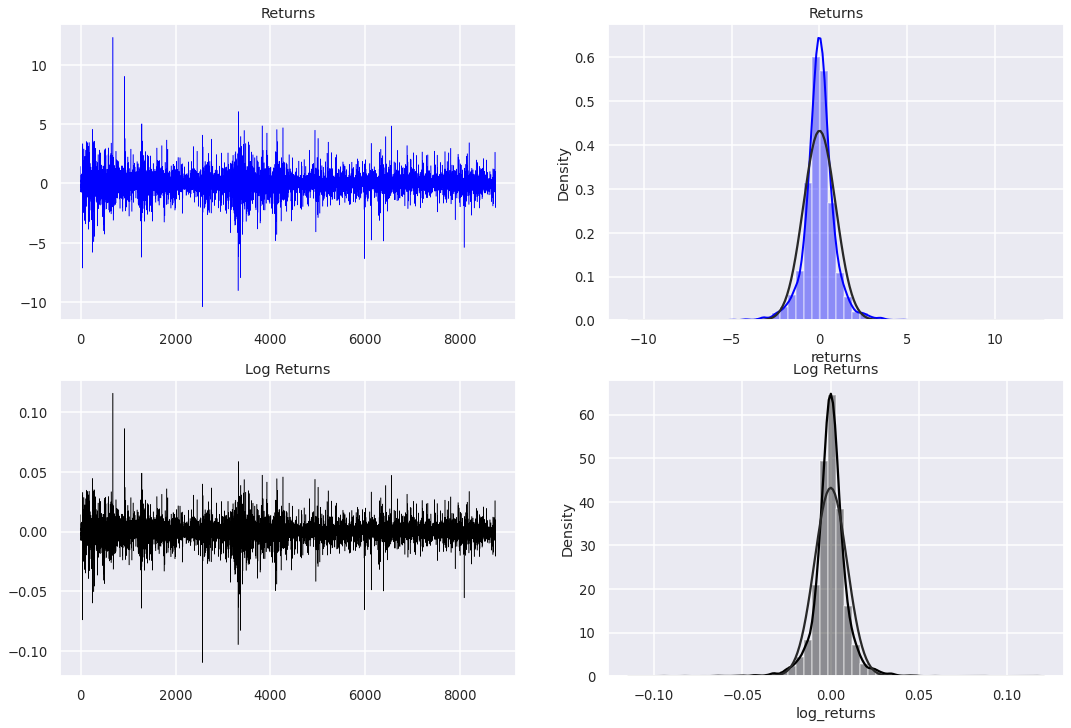

In [9]:
# Distributions of returns and log-returns
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))
    axes[0][0].plot(df.returns, color='blue', linewidth = 0.5)
    axes[0][0].set_title('Returns')

    sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1], kde_kws=dict(linewidth=2))
    axes[0][1].set_title('Returns')

    axes[1][0].plot(df.log_returns, color='black', linewidth = 0.5)
    axes[1][0].set_title('Log Returns')

    sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='black',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('Log Returns')
    fig.show();

positive kurtosis - higher peak than the standard normal distribution

In [10]:
df.returns.describe()

count    8751.000000
mean        0.009632
std         0.922313
min       -10.412877
25%        -0.410821
50%         0.005111
75%         0.422726
max        12.315896
Name: returns, dtype: float64

In [11]:
df.log_returns.describe()

count    8751.000000
mean        0.000054
std         0.009233
min        -0.109959
25%        -0.004117
50%         0.000051
75%         0.004218
max         0.116145
Name: log_returns, dtype: float64

The volatility for a certain fixed interval window (INTERVAL_WINDOW) is the standard deviation of log returns, or the square root of the sum of squares of log returns.

In [12]:
# Calculate realized_volatility 
def realized_volatility_hourly(series_log_return):
    """
    Get the realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

# Interval Window Selection

In this project, I use interval window of h_hour hours. The goal here is to forecast the average realized volatility of the next n_future hour using all previous available datapoint with GARCH models. 

In [13]:
# Intervals equal to 4 hours, 1 day, 3 days and 10 days
intervals = [4, 24, 72, 240]
vols_df = {}

# Iterate over intervals
for i in intervals:
    # get hourly log_returns of the interval
    vols = df.log_returns.rolling(window=i).apply(realized_volatility_hourly).values
    vols_df[i] = vols

# Convert vols_df from dictionary to pandas dataframe
vols_df = pd.DataFrame(vols_df, columns=intervals, index=df.index)

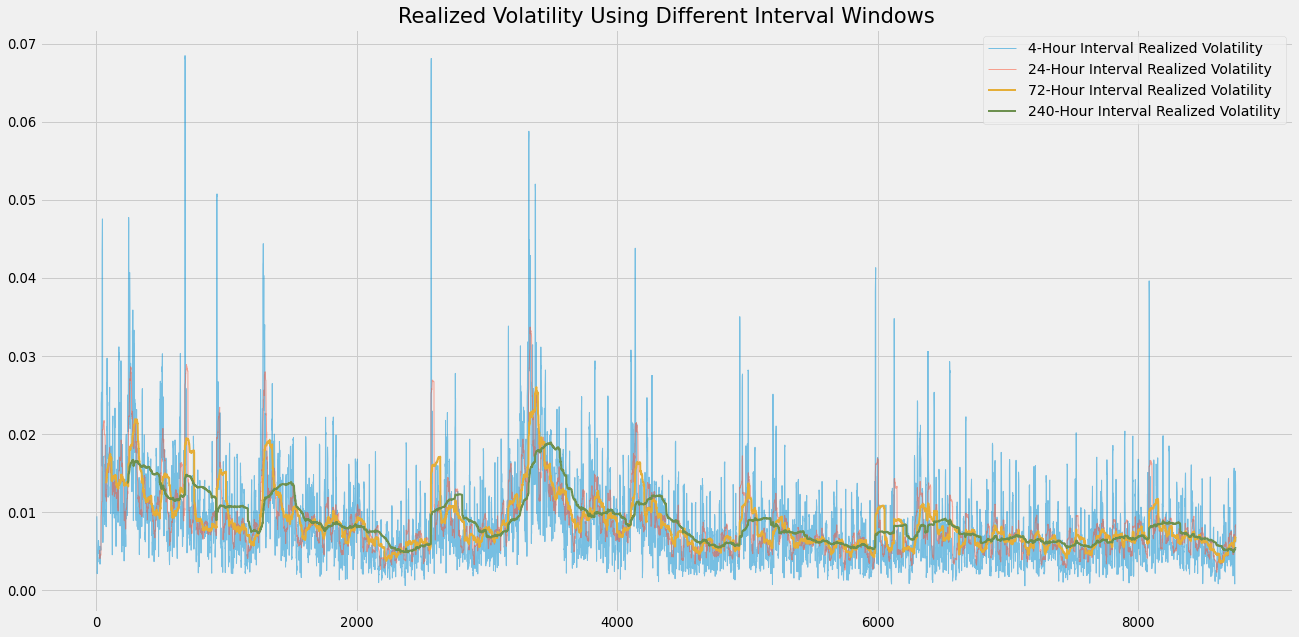

In [14]:
# Plot the realized_volatility of different inverval windows
plt.style.use(['fivethirtyeight'])
fig, ax = plt.subplots(figsize=(20,10))
for i in intervals:
    if i == 4 or i == 24:
        alpha = 0.5
        lw = 1
    if i == 72 or i == 240:
        alpha = 1
        lw = 2
    ax.plot(vols_df[i], label=f'{i}-Hour Interval Realized Volatility',alpha=alpha, lw=lw)
    
ax.set_title('Realized Volatility Using Different Interval Windows', fontsize=21)
plt.legend(loc='best', prop={'size': 14})
plt.show()

The reason I selected 24 hours is because 4 hours seems too noisy to observe meaningful patterns, while longer intervals seem to smooth the volatility down significantly and tend to revert back to the mean.

Using interval window of 24 hours would also help avoid wasting too many datapoints at the beginning of the dataset.

Time-series forecasting models are the models that are capable to predict future values based on previously observed values. Target "future" data in this case is obtained by shifting the current volatility backward by the number of n_future  lags.

For example, respected to last 3 hours, this 3 hour is the "future"; therefore I just need to shift the volatility at this 3 hours back by 3 hours, and use it as the desired "future" output for last 3 hours.

In [15]:
INTERVAL_WINDOW = 24
n_future = 1

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW).apply(realized_volatility_hourly)

# GET FORWARD LOOKING REALIZED VOLATILITY 
df['vol_future'] = df.log_returns.shift(-n_future).rolling(window=INTERVAL_WINDOW).apply(realized_volatility_hourly)

df.describe()

,price_open,price_close,price_high,price_low,volume,returns,log_returns,recal,vol_current,vol_future
count,8751.000000,8751.000000,8751.000000,8751.000000,8751.000000,8751.000000,8751.000000,8751.000000,8728.000000,8727.000000
mean,47359.701564,47361.720855,47657.894080,47042.025964,2890.768529,0.009632,0.000054,0.000054,0.008451,0.008451
std,9815.678373,9813.453376,9819.328614,9812.774066,2278.483908,0.922313,0.009233,0.009233,0.004198,0.004199
min,28995.130000,29000.010000,29125.320000,28130.000000,0.000000,-10.412877,-0.109959,-0.109959,0.002273,0.002273
25%,38078.930000,38082.560000,38418.325000,37724.885000,1495.962925,-0.410821,-0.004117,-0.004117,0.005780,0.005780
50%,47896.000000,47898.650000,48150.000000,47623.000000,2271.221516,0.005111,0.000051,0.000051,0.007363,0.007363
75%,56234.285000,56233.305000,56523.520000,55809.725000,3480.184885,0.422726,0.004218,0.004218,0.009679,0.009679
max,68635.120000,68633.690000,69000.000000,68451.190000,32057.769171,12.315896,0.116145,0.116145,0.033697,0.033697


Since I am currently using an INTERVAL_WINDOW of 24 and a horizon n_future of 1, the volatilty of first 24 values as well as the last 1 values of the dataframe would be NaN, and therefore need to be dropped from the dataset.

In [16]:
# Drop all the na values in the head and tail (the first 24 rows and the last n_future rows)
df.dropna(inplace=True)
df = df.set_index("time")
df.head()

,market,price_open,price_close,price_high,price_low,volume,returns,log_returns,recal,vol_current,vol_future
time,,,,,,,,,,,
2021-01-02 00:00:00+00:00,btc,29331.70,29197.48,29338.59,28946.53,2638.159379,-0.457560,-0.004586,-0.004586,0.005143,0.004360
2021-01-02 01:00:00+00:00,btc,29197.93,29359.47,29400.00,29100.00,1891.997249,0.554808,0.005533,0.005533,0.004360,0.004089
2021-01-02 02:00:00+00:00,btc,29359.46,29323.82,29469.00,29320.01,1704.830137,-0.121426,-0.001215,-0.001215,0.004089,0.004050
2021-01-02 03:00:00+00:00,btc,29323.82,29351.95,29382.49,29256.85,1158.041761,0.095929,0.000959,0.000959,0.004050,0.004029
2021-01-02 04:00:00+00:00,btc,29351.95,29349.63,29396.00,29220.00,988.711070,-0.007904,-0.000079,-0.000079,0.004029,0.004367


# Exploratory Data Analysis

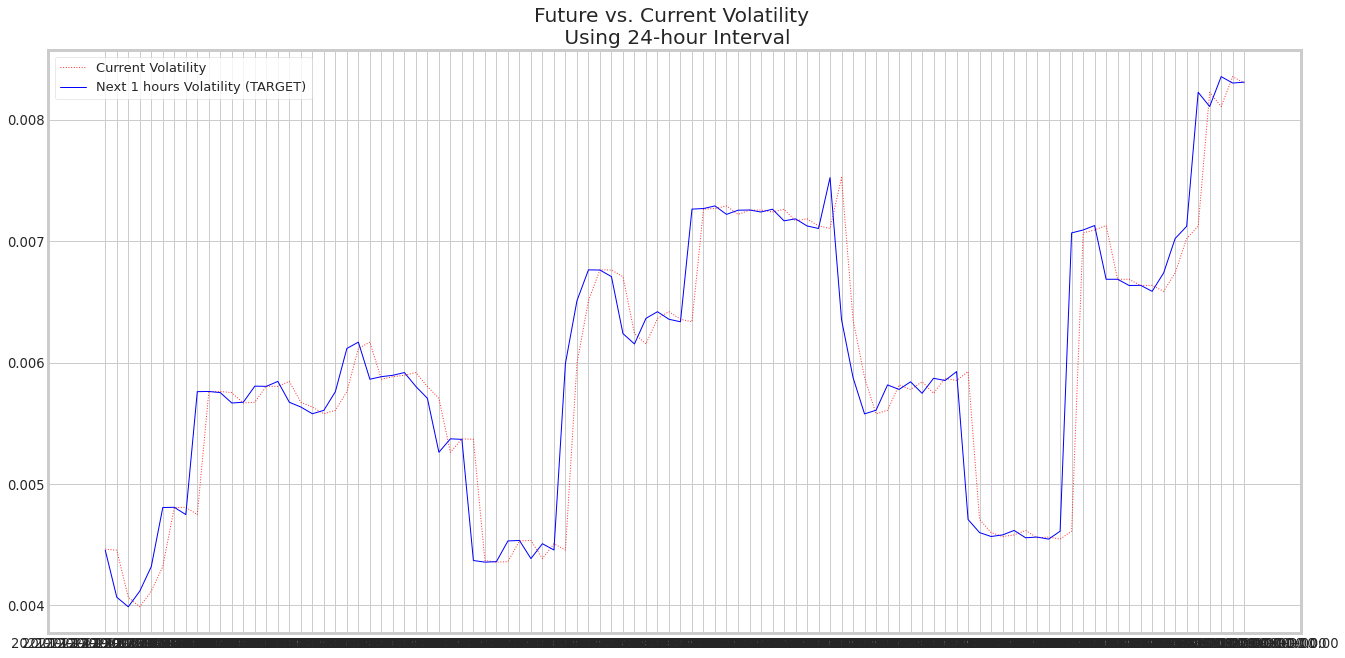

In [17]:
# Plot my desired target outputs vol_future with respect to the current volatility vol_current
#  Zoom in the most recent 100 hours.
n_zoom = 100
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(df.vol_current[-n_zoom:], alpha=.8, lw=1, color='red', ls=':',label='Current Volatility')
    ax.plot(df.vol_future[-n_zoom:], lw=1, color='blue',label=f'Next {n_future} hours Volatility (TARGET)')

    ax.title.set_text(f'Future vs. Current Volatility \n Using {INTERVAL_WINDOW}-hour Interval')

    ax.legend(loc='upper left', prop={'size': 13}, frameon=True)
    
plt.show();

In the plot above, the blue line indicates the target future value that I ultimately try to match up to.
The dotted gray line represents the current volatility in real-time.

# Train-Validation-Test Splits

Percent of the whole dataset:
- Final Model Testing - approx. 1%
- Validation and Model Tuning during training - approx. 19%
- remaining for Training - approx. 80%

In [18]:
# PRE-DETERMINE DESIRED TEST & VALIDATION SIZES
N = df.shape[0]
test_size = int(np.floor(0.01*N))
val_size = int(np.floor(0.19*N))

# CONVERT TO INDICES
split_time_1 = N - (val_size + test_size)
split_time_2 = N - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [19]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} hours')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} hours')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} hours')

TRAINING 	From: 2021-01-02 00:00:00+00:00 	to: 2021-10-20 05:00:00+00:00 	6982 hours
VALIDATION 	From: 2021-10-20 06:00:00+00:00 	to: 2021-12-28 07:00:00+00:00 	1658 hours
TEST 		From: 2021-12-28 08:00:00+00:00 	to: 2021-12-31 22:00:00+00:00 	87 hours


The target here would be vol_future which represents the hourly realized volatility of the next n_future hours from now (average hourly volatility from t + n_future - INTERVAL_WINDOW to time step t + n_future).

For example, using an n_future value of 3 and an INTERVAL_WINDOW of 24, the value that I want to predict at time step t would be the average hourly realized volatility from time step t-20 to time step t+3.

In [20]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS 
# (this would be the target)
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

In [21]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS 
# (this would be the input)
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]

In [22]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[train_idx]
r_val = df.returns[val_idx]
r_test = df.returns[test_idx]

In [23]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

# Data Preprocessing

### Volatility Normalization

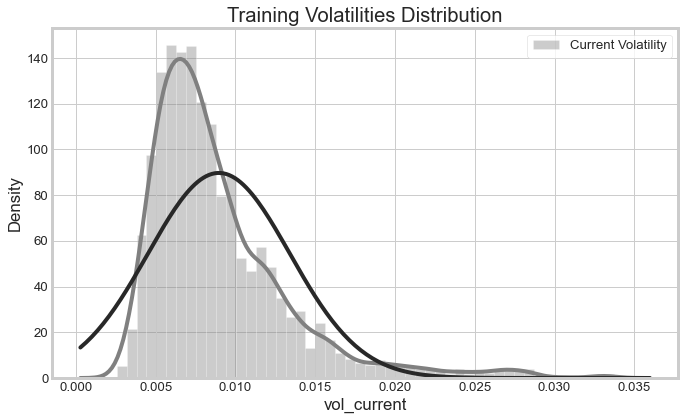

In [24]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train, norm_hist=True,  fit=stats.norm, color='gray', bins=50, ax=ax, label='Current Volatility')
#     sns.distplot(y_train, norm_hist=True,  fit=stats.norm, color='blue', bins=50, ax=ax, label='Current Volatility')
    plt.title('Training Volatilities Distribution')
    plt.legend()
    plt.show();

In [25]:
x_train.head(5)

time
2021-01-02 00:00:00+00:00    0.005143
2021-01-02 01:00:00+00:00    0.004360
2021-01-02 02:00:00+00:00    0.004089
2021-01-02 03:00:00+00:00    0.004050
2021-01-02 04:00:00+00:00    0.004029
Name: vol_current, dtype: float64

In [26]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],index=idx)
    return output

In [27]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [28]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES 
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

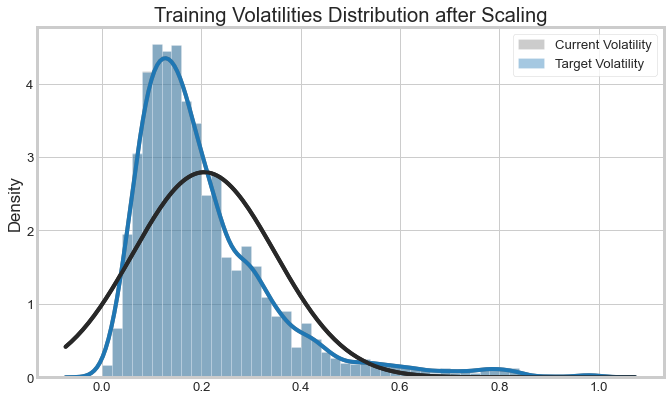

In [29]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train_scaled, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train_scaled, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution after Scaling')
    plt.legend()
    plt.show();

# Modeling

In [30]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")
        
        plt.plot(y_true, color='blue', lw=2, 
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

### GARCH

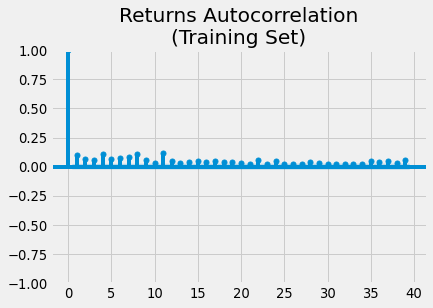

In [31]:
# ACF
plot_acf(r_train**2, title=f'Returns Autocorrelation\n(Training Set)');

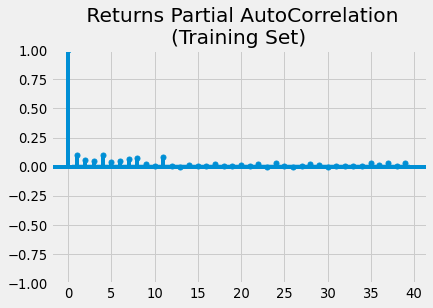

In [32]:
# PACF
plot_pacf(r_train**2, title=f' Returns Partial AutoCorrelation\n(Training Set)');

Both the ACF and PACF plots have sharp cut-offs at lag 1 and all the lags are not significant after 11th lag. Let us start with the more complex model arch(p=11, q=1).

In [33]:
gm_1 = arch_model(r_train, p=11, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9081.26
Distribution:                  Normal   AIC:                           18190.5
Method:            Maximum Likelihood   BIC:                           18286.4
                                        No. Observations:                 6982
Date:                Wed, Jun 08 2022   Df Residuals:                     6981
Time:                        22:14:32   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0203  1.064e-02      1.910  5.616e-02

In [34]:
gm_2 = arch_model(r_train, p=1, q=1)
result_2 = gm_2.fit(disp='off')
print()
print(result_2.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9082.39
Distribution:                  Normal   AIC:                           18172.8
Method:            Maximum Likelihood   BIC:                           18200.2
                                        No. Observations:                 6982
Date:                Wed, Jun 08 2022   Df Residuals:                     6981
Time:                        22:14:32   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0267  1.054e-02      2.532  1.134e-02 [6

In [35]:
gm_3 = arch_model(r_train, p=2, q=1)
result_3 = gm_3.fit(disp='off')
print()
print(result_3.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9082.39
Distribution:                  Normal   AIC:                           18174.8
Method:            Maximum Likelihood   BIC:                           18209.0
                                        No. Observations:                 6982
Date:                Wed, Jun 08 2022   Df Residuals:                     6981
Time:                        22:14:32   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0267  1.397e-02      1.910  5.613e-02

In [36]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility 
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = MinMaxScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [37]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol1 = scale_tf_cond_vol(result_1)
scaler_garch, scaled_cond_vol2 = scale_tf_cond_vol(result_2)
scaler_garch, scaled_cond_vol3 = scale_tf_cond_vol(result_3)
scaled_cond_vol2

time
2021-01-02 00:00:00+00:00    0.345776
2021-01-02 01:00:00+00:00    0.327566
2021-01-02 02:00:00+00:00    0.310613
2021-01-02 03:00:00+00:00    0.292303
2021-01-02 04:00:00+00:00    0.274689
                               ...   
2021-10-20 01:00:00+00:00    0.040206
2021-10-20 02:00:00+00:00    0.038408
2021-10-20 03:00:00+00:00    0.033906
2021-10-20 04:00:00+00:00    0.029650
2021-10-20 05:00:00+00:00    0.027078
Length: 6982, dtype: float64

In [38]:
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY 
# WITH SCALED vol_current CALCULATED ABOVE
def viz_cond_vol(cond_vol_series, model_name, n):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))
        ax.plot(x_train_scaled[:n], color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Hour Interval Hourly Realized Volatility')
        ax.plot(cond_vol_series[:n], color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show()

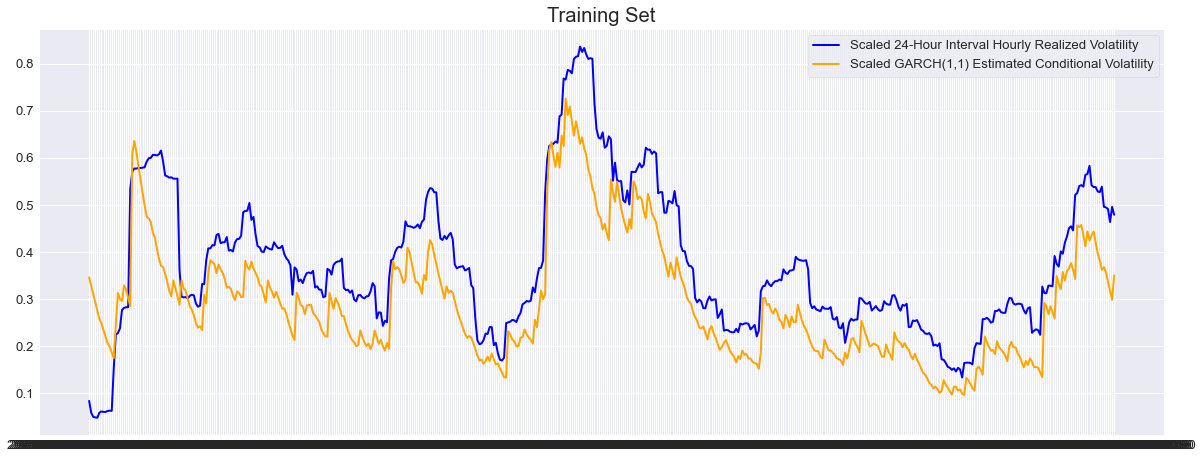

In [39]:
viz_cond_vol(scaled_cond_vol2, 'GARCH(1,1)', 500)

From the summary statistics above, GARCH(1, 1) has all significant parameters and its log-likelihood is the highest. The graph also shows that the model generally captures the trend of the scaled volatility and fits quite well with the training dataset.

### GARCH with asymmetric Shocks Responses

In [40]:
gjr_gm = arch_model(r_train, p=1, q=1, o=1, 
                    vol='GARCH', dist='skewt')
result_gjr = gjr_gm.fit(disp='off')
print(result_gjr.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -8348.88
Distribution:      Standardized Skew Student's t   AIC:                           16711.8
Method:                       Maximum Likelihood   BIC:                           16759.7
                                                   No. Observations:                 6982
Date:                           Wed, Jun 08 2022   Df Residuals:                     6981
Time:                                   22:14:48   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------

Better performance in terms of higher log-ikelihood and lower BIC.

In [41]:
scaler_gjr, scaled_cond_vol_gjr = scale_tf_cond_vol(result_gjr)

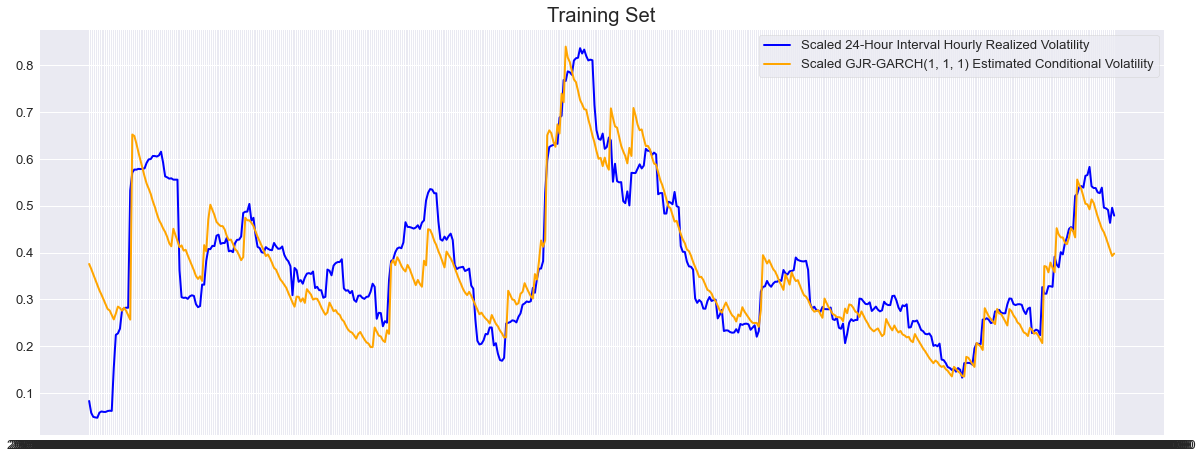

In [42]:
viz_cond_vol(scaled_cond_vol_gjr, 'GJR-GARCH(1, 1, 1)', 500)

This model fits better than the basic GARCH model.

# Validation Set - Final Model: GJR-GARCH(1,1,1)

In [44]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, 
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)
gjr_1_preds 

,0
time,
2021-10-20 06:00:00+00:00,0.543139
2021-10-20 07:00:00+00:00,0.536834
2021-10-20 08:00:00+00:00,0.529156
2021-10-20 09:00:00+00:00,0.521709
2021-10-20 10:00:00+00:00,0.520815
...,...
2021-12-28 03:00:00+00:00,0.616355
2021-12-28 04:00:00+00:00,0.742620
2021-12-28 05:00:00+00:00,0.728800


In [45]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)
gjr_1_preds_scaled

time
2021-10-20 06:00:00+00:00    0.025821
2021-10-20 07:00:00+00:00    0.023502
2021-10-20 08:00:00+00:00    0.020677
2021-10-20 09:00:00+00:00    0.017938
2021-10-20 10:00:00+00:00    0.017609
                               ...   
2021-12-28 03:00:00+00:00    0.052752
2021-12-28 04:00:00+00:00    0.099197
2021-12-28 05:00:00+00:00    0.094114
2021-12-28 06:00:00+00:00    0.088689
2021-12-28 07:00:00+00:00    0.083507
Length: 1658, dtype: float64

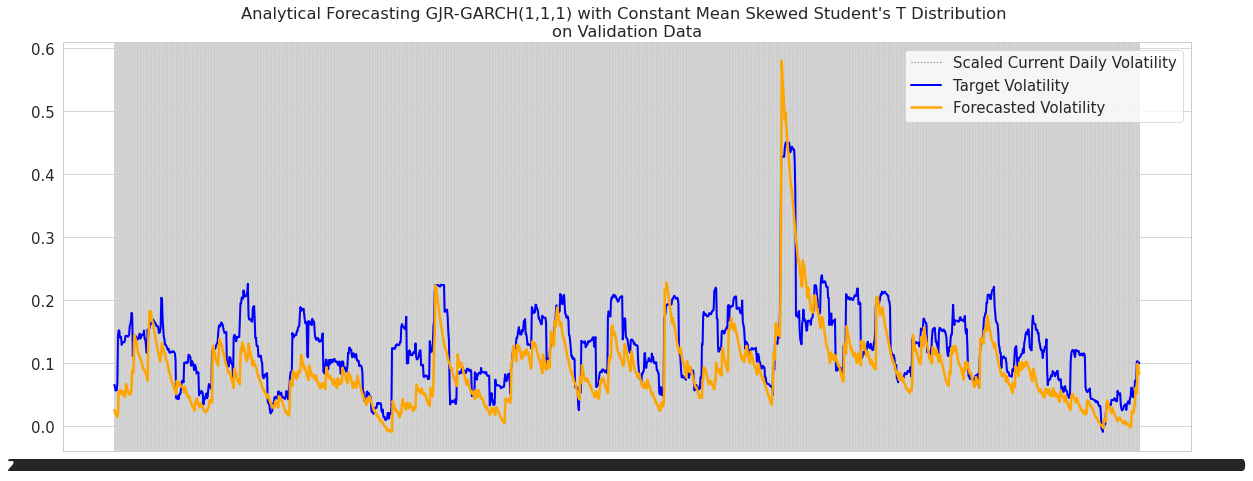

In [46]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gjr_1_preds_scaled, 
          "Analytical Forecasting GJR-GARCH(1,1,1) with Constant Mean Skewed Student's T Distribution")

# Final Function of predicting 4-hour volatility

In [55]:
def predict_volatility(df, n_future = 4, INTERVAL_WINDOW = 24):
      
    # Calculate retuns, log_returns and volatility
    df['returns'] = 100 * df.price_close.pct_change().dropna()
    df['log_returns'] = np.log(df.price_close/df.price_close.shift(1))
    df.dropna(inplace=True)
    df['vol'] = df.log_returns.rolling(window=INTERVAL_WINDOW).apply(realized_volatility_hourly)
    Vol = df['vol'].dropna()
   
    # Train model using data of all previous timestamps
    train = df['returns'].dropna()
    model = arch_model(train, p=1, q=1, o=1, vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # Make predictions on the average realized volatility of n_future hours
    vaR = model_fit.forecast(horizon=n_future, reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))
    
    # scaling back
    pred_scaled = scaler_gjr.transform([[pred]])
    forecast_vol = scaler_vol.inverse_transform(pred_scaled)
    
    # Transform hourly volatility to annual volalitility 
    annual_forecast_vol = np.sqrt(365*24) * forecast_vol
    return annual_forecast_vol 

In [56]:
# Example: use test data x_test to predict volatility
# Note here this is the annual scale
predict_volatility(df, n_future = 4)

array([[0.66122404]])

# References

https://github.com/chibui191/bitcoin_volatility_forecasting/blob/main/Notebooks/Reports/report_notebook.ipynb